# UJIIndoorLoc Response EDA and Classification - Part 2

In the [previous notebook](#UJIIndoorLoc-preprocess.ipynb), we performed various transformations on the independent variables of the raw UJIIndoorLoc dataset to prepare it for the machine learning. 

In this notebook, first, I focus on our response variables including building ID, floor ID, latitiude and longitude. Understanding the class imbalance in classification responses buildingID and floorID is important for training our machine learning models. Similarly, I analyze the distributions of our regression response variables latitude and longitude and their relationship with the building ID and floor ID. Second, I formulate the localization problem for the machine learning. Finally, I begin constructing machine learning framework first by focusing on regression without Floor and Building information. In future notebooks, I will model and evaluate cascade machine learning frameworks that perform building and floor classification before applying building and floor-optimized regression models.

## Table of Contents

1. [Setup](#setup)

2. [Response EDA](#response-eda)

3. [Problem Formulation](#problem-formulation)

4. [Multi-Variable Multivariate Regression](#regression)
                
6. [Conclusion](#conclusion)

<p><a name="setup"></a></p>

## 1. Setup

In [1]:
# Data Collection and Transformations
import numpy as np
import pandas as pd
import datetime as dt
import time
import pickle
from sklearn.preprocessing import Imputer, StandardScaler

# Statistical Testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve, validation_curve

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor


import xgboost as xgb
from xgboost.sklearn import XGBRegressor

from sklearn.pipeline import Pipeline

# Class imbalance 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# Plotting 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize'] = [10,8]
import seaborn as sns
%matplotlib inline

import warnings

Loading the transformed data from our previous notebook.

In [2]:
X_pca_crossval = pd.read_csv("data/X_pca_crossval.csv",index_col=0)
y_crossval = pd.read_csv("data/y_crossval.csv",index_col=0)

X_pca_holdout = pd.read_csv("data/X_pca_holdout.csv",index_col=0)
y_holdout = pd.read_csv("data/y_holdout.csv",index_col=0)

X_raw_crossval = pd.read_csv("data/X_raw_crossval.csv",index_col=0)
X_raw_holdout = pd.read_csv("data/X_raw_holdout.csv",index_col=0)

X_pca_crossval.shape,y_crossval.shape,X_pca_holdout.shape,y_holdout.shape

((17874, 150), (17874, 6), (1987, 150), (1987, 6))

In [3]:
X_raw_crossval.fillna(value=100,inplace=True)
X_raw_holdout.fillna(value=100,inplace=True)

<p><a name="building-eda"></a></p>

In [ ]:
y_crossval.head()

In the next few sections, we explore the characteristics of the different response variables.

<p><a name="response-eda"></a></p>

## 2. Response EDA

### 2.1 Building EDA

In [ ]:
sns.distplot(y_crossval[['BUILDINGID']],kde=False)

*Observations*:

1. In our training samples, building 2 has the clear majority with it's count being slightly lower than the sum of building 0 and building 1.

2. Building 0 and building 1 have roughly the same representation in the training data.

Clearly, there is an imbalance among the groups.

In [ ]:
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_crossval['BUILDINGID']))])

for idx, cl in enumerate(np.unique(y_crossval['BUILDINGID'])):
        plt.scatter(x=y_crossval.loc[y_crossval.BUILDINGID== cl]['LATITUDE'], 
                    y=y_crossval.loc[y_crossval.BUILDINGID== cl]['LONGITUDE'],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend(loc='upper right')
plt.tight_layout()

The above plot illustrates the locations of the buildings in the campus.

In [ ]:
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y_crossval['BUILDINGID']))])

for idx, cl in enumerate(np.unique(y_crossval['BUILDINGID'])):
        plt.scatter(x=X_pca_crossval.loc[y_crossval.BUILDINGID== cl].iloc[:,0], 
                    y=X_pca_crossval.loc[y_crossval.BUILDINGID== cl].iloc[:,1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='lower right')
plt.tight_layout()

The above plot illustrates how the buildingID are distributed across the top two PCA dimensions. Later, I explore the machine learning approaches for the building classification.

Remember PCA is an *unsupervised learning* technique for dimensionality reduction. So, it is quite possible the two top PCA components might not have explained our response variable well.

<p><a name = "floor-eda"></a></p>

### 2.2 Floor EDA

In [ ]:
sns.countplot(x="FLOOR", hue="BUILDINGID", data=y_crossval,orient="v")

*Observations*:
    
1. Buildings 0 and 1 have 4 floors whereas Building 2 has 5 floors.

2. Expectedly, the samples from Building 2 are consistently the highest across all the floors.

<p><a name="Problem Formulation"></p>

<p><a name="problem-formulation"></a></p>

## 3. Problem Formulation

### 3.1 Error Metric

The overall goal of this project is to build models for accurate indoor localization. The mean positioning error expressed as the mean Euclidean distance between the real and estimated locations. **However, in multi-building, multi-floor environments as in our problem, just the positioning error due to Euclidean distance is not enough.** Wrong floor and wrong building classification are not desirable as the actual movement from the predicted location to the actual location might involve great displacement.

Therefore, we include penalty terms to the mean error equation to penalize failures in floor and building classification. This was introduced in the [2015 EvAAL-ETRI competition](http://content.iospress.com/articles/journal-of-ambient-intelligence-and-smart-environments/ais421). The cost function can be expressed as follows:

$positioning\_error(actual,predicted)= euclidean\_distance(actual,predicted) + penalty_{floor}*fail_{floor} + penalty_{building}*fail_{building}$

where $fail_{floor}$ and $fail_{building}$ indicate if the floor and building are incorrectly identified, $penalty_{floor}$ and $penalty_{building}$ are the penalty values applied for wrongful classification of floor and building respectively. The penalty values were set to 4 and 50 respectively in the third track of the competition ([Source](http://ieeexplore.ieee.org/document/7743679/)). Expectedly, the penalty for building classification failure is higher than that of floor classification failure. In this project, I utilize the same penalty term values for the error metric.

### 3.2 Machine Learning Methodology

Because of the added penalty terms, we cannot simply perform regression for the Latitude and Longitude. Separate models might have to be trained per-floor and per-building. Hence, the building and floor need to be classified first.

However, I first analyze the regression variables in isolation without incorporating the buildingID and FloorID. The framework built will be used for comparison against the Cascade framework that incorporates the building and floor information.

<p> <a name = "regression"></a></p>

## 4. Multi-Variable Multivariate Regression

**The key concepts of building the regression framework include:**

1. *MultiOutputRegressor*: We have the response as a vector of 2-dimensions (Latitude and Longitude). Not every regression method in scikit-learn can handle this sort of problem. Most linear models provide this capability but for those that don't, a new class MultiOutputRegressor is available for parallelization of regressors for multivariate output.

2. *Linear Regression Models*: First, I will focus on Linear regression and its variants including Lasso, Kernel Ridge.

3. *Polynomial Features*: Consider Polynomial Features including quadratic and cubic for addressing non-linearities.

4. *Other Regression Models*: ExtraTreesRegressor, RandomForestRegressor, XGBoostRegressor

5. *Stacking*: Simple Average, XGBoost stacking as shown in this [Kaggle kernel](https://www.kaggle.com/eliotbarr/house-prices-advanced-regression-techniques/stacking-starter/run/598752).

In [4]:
X_train = np.array(X_pca_crossval)
y_train = y_crossval[['LATITUDE','LONGITUDE']]

X_test = np.array(X_pca_holdout)
y_test = y_holdout[['LATITUDE','LONGITUDE']]

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((17874, 150), (17874, 2), (1987, 150), (1987, 2))

In [5]:
# Dictionary to store nested cross-validation scores
model_scores = {}

# Dictionary to store model and param grid mapping
model_param_grid = {}

In the next few sub-sections, we perform nested cross-validation on the different model families. In nested cross-validation, the inner fold performs the parameter tuning and the outer fold is used for the validation performance.

Before we begin the model assessment, let's write a function to simplify the nested cross-validation operation.

### 4.1 Nested Cross-Validation

In [11]:
def nested_crossval(reg_list,reg_labels, model_param_grid=model_param_grid, model_scores = model_scores,
                    X = X_train, y= y_train, label_extension = None):
    '''
    Inputs:
    reg_model        : List of Regression model instances
    reg_label        : List of Regression model labels
    model_param_grid : List of parameter grids
    X                : explanatory variables 
    y                : response variable array
    model_scores     : Dictionary to store nested cross-validation scores
    label_extension  : Extension to regression label in model_scores key
    
    Outputs:
    model_scores     : Updated dictionary of nested cross-validation scores
    '''

    
    for reg_model, reg_label in zip(reg_list, reg_labels):
    
        #print(param_grid)
    
        gs = (GridSearchCV(estimator=reg_model, 
                            param_grid=model_param_grid[reg_label], 
                            cv=2,
                            scoring = 'neg_mean_squared_error',
                            n_jobs = 1))
    
        scores = cross_val_score(estimator=gs,
                                 X=X,
                                 y=y,
                                 cv=5,
                                 scoring='neg_mean_squared_error')
        scores = np.sqrt(np.abs(scores))
        
        if label_extension:
            reg_label += '_' + label_extension
        
        print("RMSE: %0.2f (+/- %0.2f) [%s]"
              % (scores.mean(), scores.std(), reg_label))
        
        model_scores[reg_label] = scores
        
    
    return model_scores

### 4.2 Linear Models and Variants

In this sub-section, I analyze the performance of Linear Regression models and its regularization variants.

In [10]:
## Linear Models

# Ridge Regression
pipe_ridge = Pipeline([('scl', StandardScaler()),
            ('reg', Ridge(random_state=1))])

# Lasso
pipe_lasso = Pipeline([('scl', StandardScaler()),
            ('reg', Lasso(random_state=1))])

param_grid_lm= {
    'reg__alpha':[0.01,0.1,1,10],
}

reg_lm = [pipe_ridge,pipe_lasso]
reg_labels_lm = ['Ridge','Lasso']
model_param_grid['Ridge'] = param_grid_lm
model_param_grid['Lasso'] = param_grid_lm

model_scores = nested_crossval(reg_lm,reg_labels_lm)

RMSE: 25.25 (+/- 0.41) [Ridge]
RMSE: 25.26 (+/- 0.43) [Lasso]


In [11]:
model_scores

{'Lasso': array([ 25.49069375,  24.50169635,  25.78675344,  25.24330896,  25.29979238]),
 'Ridge': array([ 25.43926941,  24.53596898,  25.780613  ,  25.20794527,  25.30487622])}

Interestingly, ridge regression and Lasso provide nearly the same performance but still very far from our baseline of 7.5m.

### 4.2 Polynomial Regression

In this sub-section, we analyze the non-linear variations of Regression by incorporating higher-order features into the Regression Analysis.

In [6]:
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X_train)

pipe_ridge_poly = Pipeline([('scl', StandardScaler()),
                            ('pca', PCA(n_components=100)),
                            ('reg', Ridge(random_state=1))])

# Lasso
pipe_lasso_poly = Pipeline([('scl', StandardScaler()),
                            ('pca', PCA(n_components=100)),
                            ('reg', Lasso(random_state=1))])

reg_lm_quad = [pipe_ridge_poly,pipe_lasso_poly]
reg_labels_lm_quad = ['Ridge_Quadratic','Lasso_Quadratic']
model_param_grid['Ridge_Quadratic'] = param_grid_lm
model_param_grid['Lasso_Quadratic'] = param_grid_lm

model_scores = nested_crossval(reg_lm_quad,reg_labels_lm_quad, X= X_quad)

In [13]:
# First, let's save our data into a file
f = open("model_scores_lm.pckl", "wb")
pickle.dump(model_scores,f)

In [15]:
pkl_file = open('model_scores_lm.pckl', 'rb')

model_scores = pickle.load(pkl_file)

In [16]:
model_scores

{'Lasso': array([ 25.49069375,  24.50169635,  25.78675344,  25.24330896,  25.29979238]),
 'Ridge': array([ 25.43926941,  24.53596898,  25.780613  ,  25.20794527,  25.30487622])}

In [ ]:
cubic = PolynomialFeatures(degree=3)
X_cubic = cubic.fit_transform(X_train)

reg_lm_cube = [pipe_ridge_poly,pipe_lasso_poly]
reg_labels_lm_cube = ['Ridge_Cubic','Lasso_Cubic']
model_param_grid['Ridge_Cubic'] = param_grid_lm
model_param_grid['Lasso_Cubic'] = param_grid_lm

model_scores = nested_crossval(reg_lm_cube,reg_labels_lm_cube, X= X_cubic)

### 4.3 K Nearest Neighbors Regression

In [16]:
pipe_knn = Pipeline([('scl', StandardScaler()),
            ('reg', KNeighborsRegressor())])

grid_param_knn = {
    'reg__n_neighbors': [2,3,5,7],
    'reg__weights': ['uniform','distance'],
    'reg__metric': ['euclidean','minkowski','manhattan'],
    'reg__n_jobs': [-1]
}

model_param_grid['KNN'] = grid_param_knn

model_scores = nested_crossval([pipe_knn],['KNN'])

In [18]:
# First, let's save our data into a file
f = open("model_scores_knn.pckl", "wb")
pickle.dump(model_scores,f)

In [19]:
model_scores

{'KNN': array([ 6.44366044,  5.9055819 ,  5.74672049,  5.7716296 ,  5.76268187]),
 'Lasso': array([ 25.49069375,  24.50169635,  25.78675344,  25.24330896,  25.29979238]),
 'Ridge': array([ 25.43926941,  24.53596898,  25.780613  ,  25.20794527,  25.30487622])}

### 4.4 Tree-Based Models

In [12]:
# Random Forests
reg_rf = RandomForestRegressor(random_state=1)

# Extra Trees
reg_et = ExtraTreesRegressor(random_state=1)

param_grid_tree = {
    'n_jobs': [-1],
    'n_estimators': [10,30,50,70,100],
    'max_features': [0.25,0.5,0.75],
    'max_depth': [3,6,9,12],
    'min_samples_leaf': [5,10,20,30]
}

reg_tree = [reg_rf,reg_et]
reg_labels_tree = ['Random Forests','Extra Trees']
model_param_grid['Random Forests'] = param_grid_tree
model_param_grid['Extra Trees'] = param_grid_tree

model_scores = nested_crossval(reg_tree,reg_labels_tree)

RMSE: 6.78 (+/- 0.16) [Random Forests]
RMSE: 8.89 (+/- 0.15) [Extra Trees]


In [13]:
# First, let's save our data into a file
f = open("model_scores_tree.pckl", "wb")
pickle.dump(model_scores,f)

In [8]:
pkl_file = open('model_scores_tree.pckl', 'rb')

model_scores = pickle.load(pkl_file)

In [14]:
model_scores

{'Extra Trees': array([ 9.17370814,  8.82194108,  8.75181561,  8.90668164,  8.80848569]),
 'KNN': array([ 6.44366044,  5.9055819 ,  5.74672049,  5.7716296 ,  5.76268187]),
 'Lasso': array([ 25.49069375,  24.50169635,  25.78675344,  25.24330896,  25.29979238]),
 'Random Forests': array([ 7.07787616,  6.60653919,  6.72760227,  6.80752508,  6.69423105]),
 'Ridge': array([ 25.43926941,  24.53596898,  25.780613  ,  25.20794527,  25.30487622])}

### 4.5 Other Models

In [ ]:

'''
# Support Vector Regression
pipe_svr = Pipeline([('scl', StandardScaler()),
            ('reg', MultiOutputRegressor(SVR()))])

grid_param_svr = {
    'reg__estimator__C': [0.01,0.1,1,10],
    'reg__estimator__epsilon': [0.1,0.2,0.3],
    'reg__estimator__degree': [2,3,4]
}

model_param_map[pipe_svr] = grid_param_svr

# Multi-Layer Perceptron
pipe_mlp = Pipeline([('scl', StandardScaler()),
            ('reg', MLPRegressor(random_state=1))])

grid_param_mlp = {
    'alpha': [0.0001,0.001,0.01,0.1],
    'learning_rate': ['constant','invscaling','adaptive']
}

model_param_map[pipe_mlp] = grid_param_mlp
'''

Based on the above nested cross-validation results, K Nearest Neighbors Regressor has the the lowest root mean square error for predicting latitude and longitude.

### 4.6 K Nearest Neighbors Hyper-Parameter Tuning 

In [19]:
gs_knn = (GridSearchCV(estimator=pipe_knn, 
                      param_grid=grid_param_knn, 
                      cv=10,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = 1))

gs_knn = gs_knn.fit(X_train,y_train)

In [24]:
gs_knn.best_estimator_

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
          weights='distance'))])

In [26]:
gs_knn_best = gs_knn.best_estimator_

gs_knn_best

Pipeline(steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
          metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
          weights='distance'))])

*Observations:*


#### 4.6.1 Learning Curve

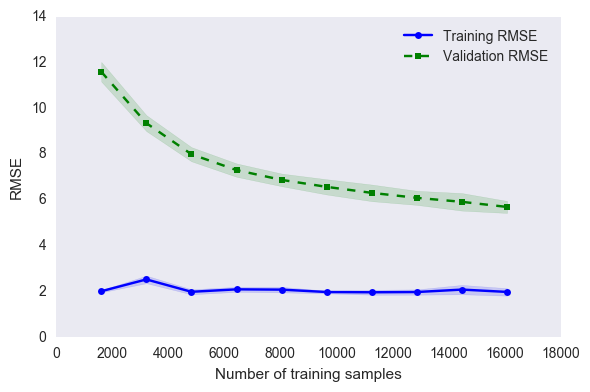

In [30]:
## Credits: Sebastien's Python Machine Learning Book
'''
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=gs_knn_best,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1,
                               scoring = 'neg_mean_squared_error'
                              )

train_scores = np.sqrt(np.abs(train_scores))
test_scores = np.sqrt(np.abs(test_scores))
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
'''

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training RMSE')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation RMSE')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('RMSE')
plt.legend(loc='upper right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

## 5. Per-Building Per-Floor Regression

The goal is to tune the KNN model per-building per-floor. However, I fear every building-floor combination might not have enough samples to build a good machine learning model.

### 4.3 XGBoost



In [ ]:
from sklearn import cross_validation, metrics

def modelfit(alg, X_train, y_train,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % metrics.mean_squared_error(y_train, dtrain_predictions))
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
    
xgb_single = XGBRegressor(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)